# Grand canonical ensemble transition-matrix Monte Carlo

In this example, flat histogram methods are employed for a small macrostate range from 0 to 5 particles.
Flat histogram acceptance criteria and Monte Carlo are defined using `fh.py`.
To begin, the system is initialized with the minimum number of particles by setting Metropolis acceptance criteria with favorable conditions for adding particles.
The Metropolis criteria are then replaced with the flat histogram criteria.
At this point, typical analysis from the previous tutorials are added.
In addition, we also add checkpoint files, criteria status, and average energy of a given macrostate.
Finally, the simulation is run until the requested number of iterations of the flat histogram algorithm are complete.

A small macrostate range allows the simulation to run quickly with good sampling, and thus it is an ideal starting point to test the simulations.

In [1]:
import sys
import unittest
import feasst
sys.path.insert(0, feasst.install_dir() + '/plugin/flat_histogram/tutorial/')
import fh

class TestFlatHistogramLJ(unittest.TestCase):
    """Test flat histogram grand canonical ensemble Monte Carlo simulations"""
    def test_serial_5max(self):
        """Compare the free energies and potential energies with the NIST SRSW
        https://www.nist.gov/programs-projects/nist-standard-reference-simulation-website
        https://mmlapps.nist.gov/srs/LJ_PURE/eostmmc.htm
        """
        criteria = fh.criteria_flathist(temperature=1.5, macro_min=0, macro_max=5, tmmc=True)
        monte_carlo = fh.monte_carlo(criteria=criteria, run=False)
        monte_carlo.set(feasst.MakeCheckpoint(feasst.args(
            {"file_name": "checkpoint0.txt", "num_hours": "0.001"}))) 
        monte_carlo.run_until_complete()
        lnpi_previous = [
            [-18.707570324988800000, 1],
            [-14.037373358321800000, 0.037092307087640365],
            [-10.050312091655200000, 0.03696447428346385],
            [-6.458920624988570000, 0.037746391500313385],
            [-3.145637424988510000, 0.03809721387875822],
            [-0.045677458321876000, 0.03845757460933292]
        ]
        energy_previous = [
            [0, 1e-14], 
            [-0.0006057402333333332, 6.709197666659334e-10],
            [-0.0307, 9.649146611661053e-06],
            [-0.089928316, 0.0001387472078025413],
            [-0.1784570533333333, 3.3152449884326804e-05],
            [-0.29619201333333334, 1.3487910636322294e-05],
        ]
        for macro in range(criteria.num_states()):
            self.assertAlmostEqual(
                lnpi_previous[macro][0],
                criteria.bias().ln_prob().value(macro),
                delta=lnpi_previous[macro][1]
            )
            energy_analyzer = monte_carlo.analyze(monte_carlo.num_analyzers() - 1)
            energy_accumulator = energy_analyzer.analyze(macro).accumulator()
            stdev = (energy_previous[macro][1]**2 + energy_accumulator.block_stdev()**2)**(1./2.)
            print(energy_accumulator.average())
            self.assertAlmostEqual(
                energy_previous[macro][0],
                energy_accumulator.average(),
                #criteria.bias().ln_prob().value(macro),
                delta=5*stdev
            ) 


In [2]:
%%time
unittest.main(argv=[''], verbosity=2, exit=False)

test_serial_5max (__main__.TestFlatHistogramLJ)
Compare the free energies and potential energies with the NIST SRSW ... 

-5.505927407148185e-16
-0.0006057400016613032
-0.030541307596437715
-0.09004610630972813
-0.17866881545428673
-0.294479125837981
CPU times: user 4.59 s, sys: 564 ms, total: 5.15 s
Wall time: 5.14 s


ok

----------------------------------------------------------------------
Ran 1 test in 5.142s

OK


A number of files should also have been created.
If the flat histogram method is sampling perfectly, the simulation performs a random walk along the macrostate.
For larger ranges of macrostates, or for more difficult sampling cases, monitoring the macrostate can help you determine what conditions are preventing convergence.
For example, a plot of the macrostate as a function of the number of attempts may look like the following:


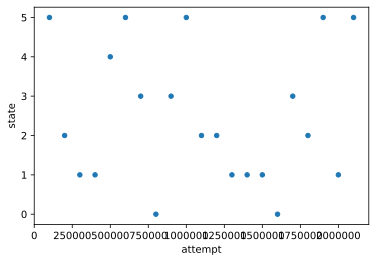

In [3]:
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt

df=pd.read_csv("log0.txt", header=0).plot('attempt', 'state', kind='scatter')

The energy of each macrostate may also be visualized and compared with the published values in the NIST SRSW.

Text(0.5, 0, 'macrostate')

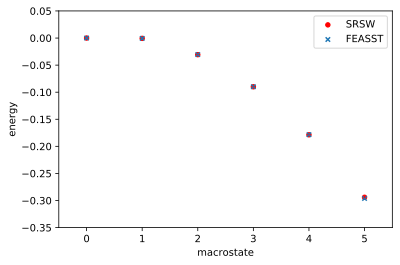

In [4]:
import pyfeasst

label='energy'
num_processors=1

def combine_energy(append='state'):
    """Aggregate individual files into one data frame"""
    dfall = list()
    for proc in range(num_processors):
        monte_carlo = feasst.MonteCarlo().deserialize(
            pyfeasst.read_checkpoint("checkpoint" + str(proc) + ".txt"))
        for state in range(monte_carlo.criteria().num_states()):
            df = pd.read_csv("energy" + str(proc) + ".txt_" + append + str(state))
            df['state'] = state
            dfall.append(df)
    return pd.concat(dfall)

en = combine_energy()
ax = en.plot('state', 'average', yerr=en['block_stdev'], kind='scatter', color='red')
dfsrsw = pd.read_csv("../test/data/stat150.csv")
ax = dfsrsw.plot('N', 'energy', yerr=dfsrsw['energystd'], kind='scatter',
                                                  ax=ax, style='x', xlim=[-0.5,5.5], ylim=[-0.35, 0.05], 
                                                  marker='x', legend=True)
ax.legend(['SRSW', 'FEASST'])
plt.xlabel('macrostate')

You may also plot the natural logarithm of the macrostate probability

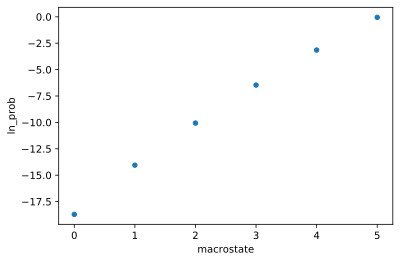

In [5]:
label='ln_prob'

def combine_criteria(prepend='crit'):                                  
    """Combine multiple criteria files together, assuming that the last macrostate in the ith
    file is equivalent to the first macrostate in the (i+1)th file.
    """
    dfall = list()                                       
    prev = 0                                             
    for proc in range(num_processors):              
        df1 = pd.read_csv(prepend+str(proc)+".txt", header=3)
        df1[label + "_combine"] = df1[label]   
        df1[label + "_combine"] += prev - df1[label].iloc[0]
        dfall.append(df1)
        prev = df1[label].iloc[-1]
    return pd.concat(dfall)

combine_criteria().plot('macrostate', 'ln_prob', kind='scatter')

The macrostate probability distribution depends upon the choice of the chemical potential, but can be reweighted to different chemical potentials.

Did this tutorial work as expected? Did you find any inconsistencies or have any comments? Please [contact](../../../CONTACT.rst) us. Any feedback is appreciated!